# HDR
This document implements some of the HDR methods for series of XRAY images using opencv.
The pictures are loaded from the hdr directory (the intput directory path can be chnaged in code below)
The algorithm and the document are devided into the four parts:

* Initialization - load dependencies, load images and show imput images in figure. I also print the exposure values used for debvec and robertson algorithms.

* Corection curve estimation.

* Mergin images - merge the image data set using all of the methods. In case of Merthems the exposures are not used.

* Apply tone mapping - applies one of the tone mapping on merge results (Drago, Durand, Reinhard or Mantiuk).

Implemented algorithms are Robertson, Debvec and Mertens. The result are shown in plots using several tone mapping methods.

## Input data

There are two types of input data:

* Calibration data for calibration curve estimation - images which has overexposed (directly iradiated) areas, underexposed (radiation absorbed by some object - lead (Pb))  areas and areas which intensity changes with exposure change. Every image shoudl be taken with different expoure - usually is recomended time delta 1 stop. So the calibration data could be for example 4 images which will have overexposed area, underexposed area and "normal" area which change its intensity according to exposure time and which will be taken whit exposure time 1000 ms, 500 ms, 250 ms and 125 ms.

* Input data - data for hdr image reconstruction. This data should be taken in the same way as the calibration data. Image with the lowest exposure time should be underexposed and image with the highest exposure time should be overexposed.

Calibration and input data could look like this:

![input_data](resources/input_data.png)

![calib_data](resources/calib_data.png)


## Results

I've got following results for calibration and input data above using code presented in the next part of notebook:

![result](resources/result.png)

## Initialization

As I mentioned following code tries to load dependencies, images from the hdr path and parse exposure constants. Exposure constant are parsed from the image file names using folowing pattern:

* "somestring...xxxxms...somestring" where xxxx is exposure in miliseconds, which will be parsed. So for [298]50kV-300uA-400ms 
the exposure will be 400 ms.

All of the images (input and calibration) are preprocessed in the following way:

* loaded as 16 bit images using opecv (my test data from detector are coded as 14 bit information in 16 bits)

* scaled from 14 bits to 8 bits (this is done because opencv too, it works only with 8 bit depth)

* stacked into 3 channels (because opnecv methods works just with 3 channel images) 

* converted whole array to uint8 data type (we have scaled from 14 bit to 8 bit depth yet, so we don't loose any information here)

(1548, 1032, 3)


<IPython.core.display.Javascript object>


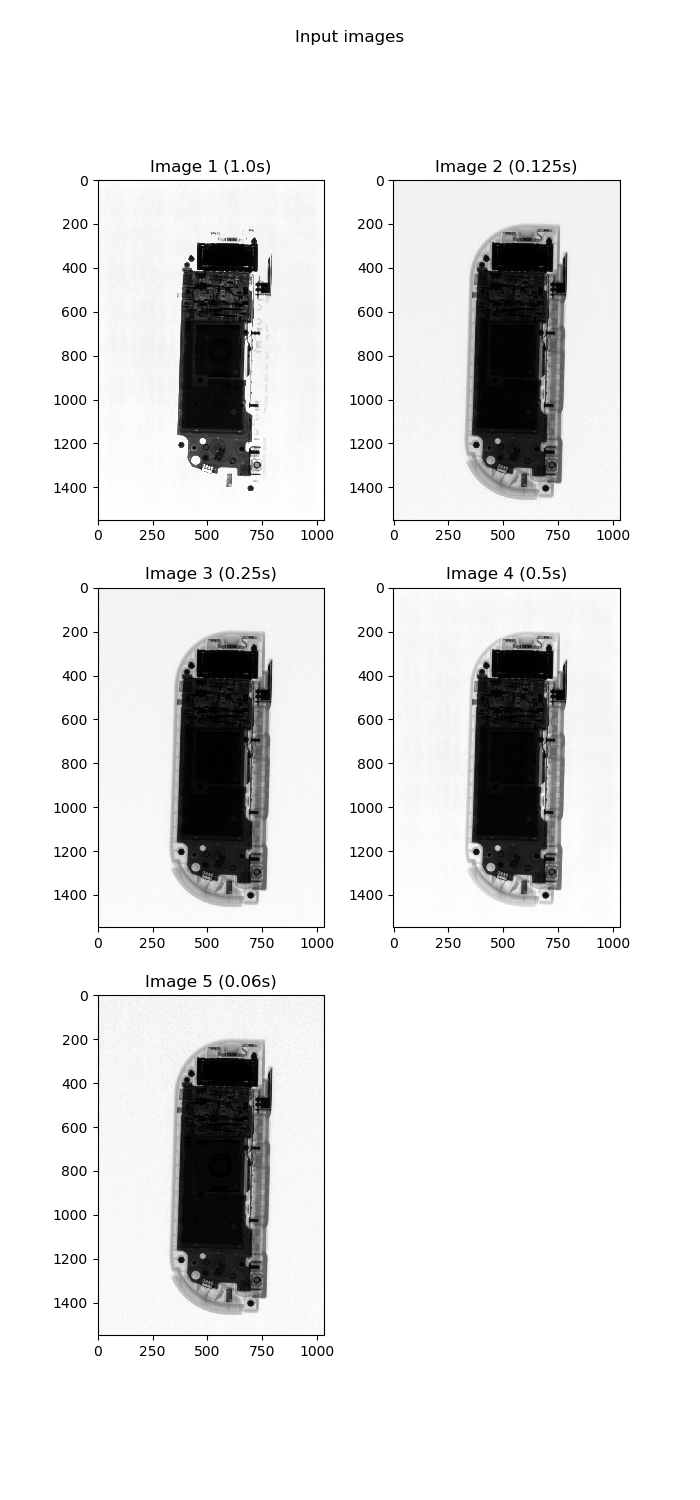

<IPython.core.display.Javascript object>


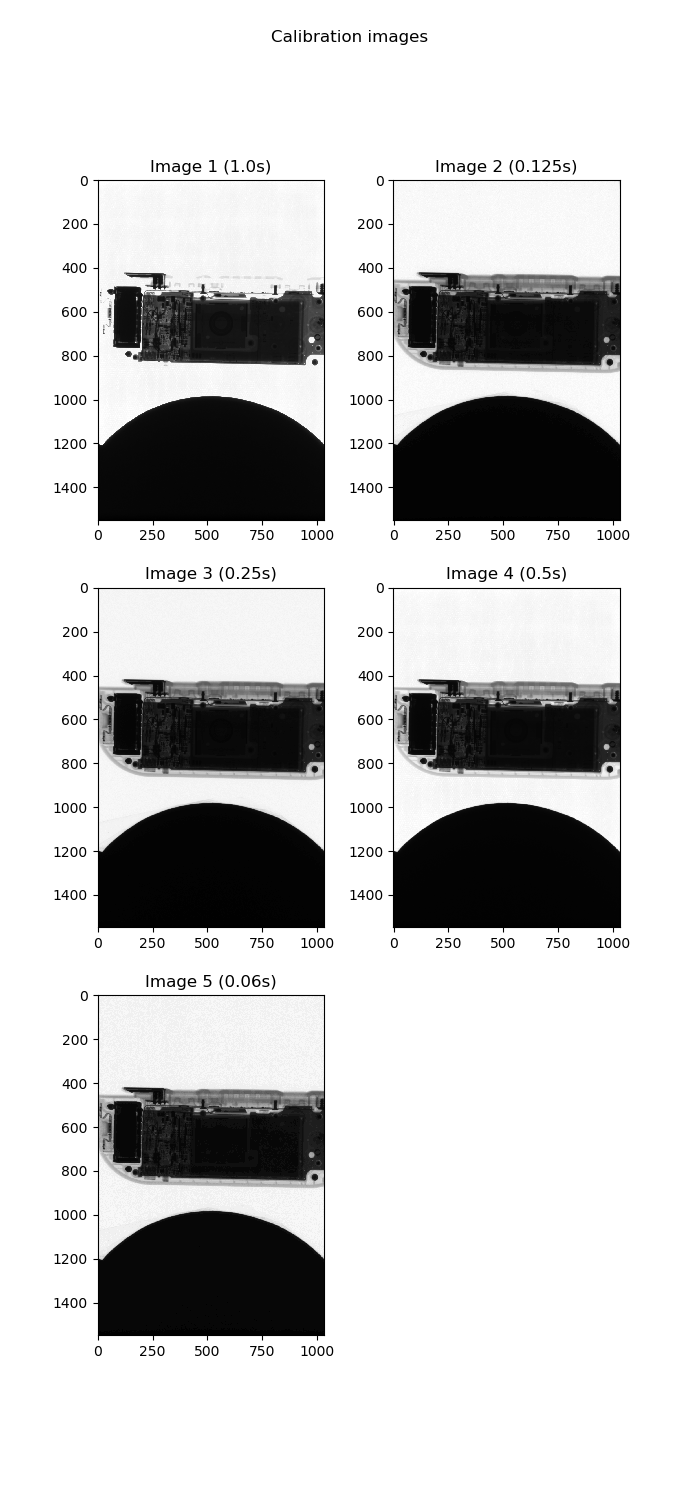

In [9]:
%matplotlib notebook

import glob
import random
import re

import matplotlib.pyplot as plt

from skimage import img_as_uint, img_as_ubyte, data
from skimage.io import imread, imsave
from skimage.exposure import rescale_intensity

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets

import numpy as np

import cv2

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

images = []
exposures = []
calib_images = []
calib_exposures = []
print((cv2.imread('./hdr_images/1000ms.tif')).shape)
# load images and its exposure
for filename in glob.glob('./hdr_images/*.tif'):
    match = re.search('\d+(?=ms)', filename)
    image = cv2.imread(filename, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    converted_image = rescale_intensity(image, (0, 2**14 - 1), (0,2**8 - 1))
    stacked_image = np.zeros(shape=(image.shape + (3,)))
    stacked_image[:,:,0] = converted_image
    stacked_image[:,:,1] = converted_image
    stacked_image[:,:,2] = converted_image
    images.append(stacked_image.astype(np.uint8))
    exposures.append(int(match.group()) / 1000)

# load calibration images and its exposure
for filename in glob.glob('./calibration_images/*.tif'):
    match = re.search('\d+(?=ms)', filename)
    image = cv2.imread(filename, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    converted_image = rescale_intensity(image, (0, 2**14 - 1), (0,2**8 - 1))
    stacked_image = np.zeros(shape=(image.shape + (3,)))
    stacked_image[:,:,0] = converted_image
    stacked_image[:,:,1] = converted_image
    stacked_image[:,:,2] = converted_image
    calib_images.append(stacked_image.astype(np.uint8))
    calib_exposures.append(int(match.group()) / 1000)

# plot input images and calibration images
f, ax = plt.subplots(int(len(images) / 2) + 1, 2,
                     figsize=(7, (int(len(images) / 2) + 1) * 5))
f.suptitle('Input images')
for idx, image in enumerate(images):
    ax[int(idx / 2), idx % 2].imshow(image[:,:,0])
    ax[int(idx / 2), idx % 2].set_title(f'Image {idx + 1} ({exposures[idx]}s)')

# hide last plot if is blank
if (idx + 1) % 2 == 1:
    ax[-1, -1].axis('off')

f, ax = plt.subplots(int(len(calib_images) / 2) + 1, 2,
                     figsize=(7, (int(len(images) / 2) + 1) * 5))
f.suptitle('Calibration images')
for idx, image in enumerate(calib_images):
    ax[int(idx / 2), idx % 2].imshow(image[:,:,0])
    ax[int(idx / 2), idx % 2].set_title(f'Image {idx + 1} ({calib_exposures[idx]}s)')

# hide last plot if is blank
if (idx + 1) % 2 == 1:
    ax[-1, -1].axis('off')
    
exposures = np.array(exposures, dtype=np.float32)
calib_exposures = np.array(calib_exposures, dtype=np.float32)

# Detector response function estimation

Following code estimates DRS for the calibrating images which are in the calibration_images directory.

<IPython.core.display.Javascript object>


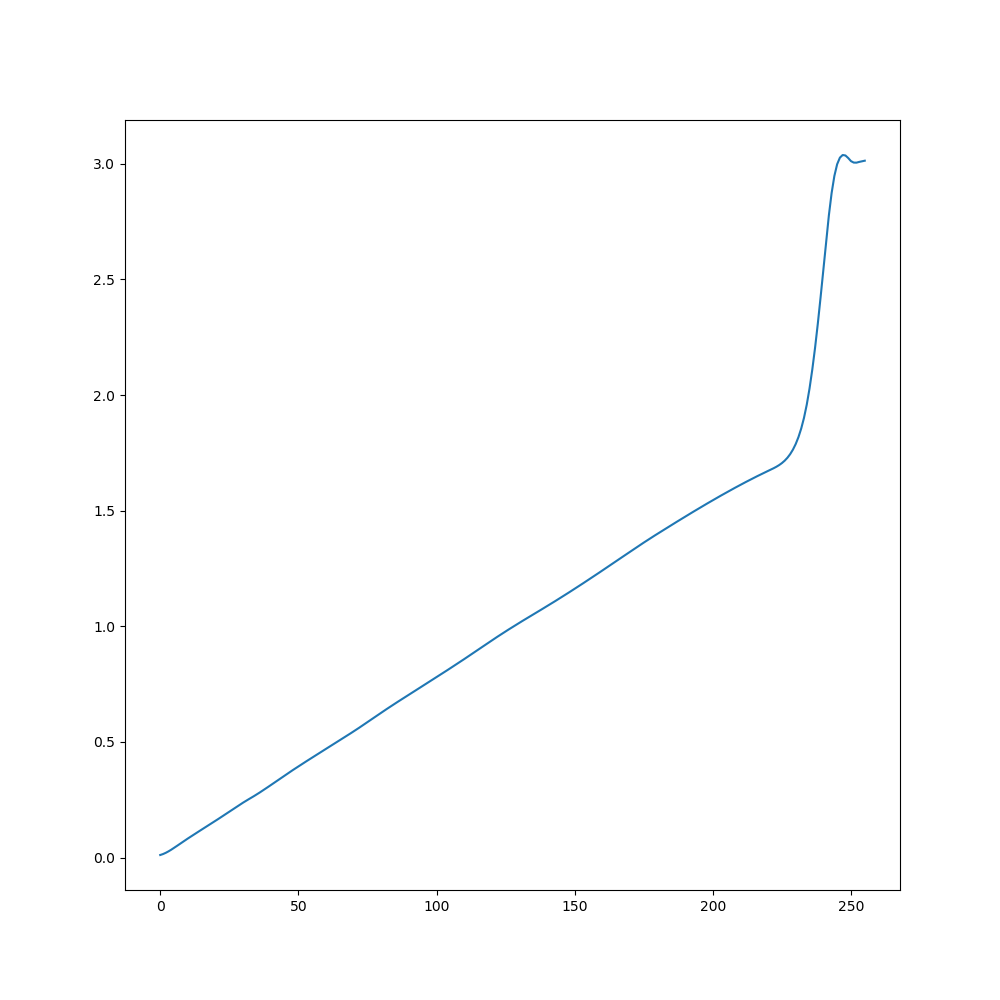

In [6]:
cal = cv2.createCalibrateDebevec(random=True)
crf = cal.process(calib_images, times=calib_exposures)

plt.figure(figsize=(10, 10))
plt.plot(crf[:,:,0])

## Merge exposure
Following code executes three mentioned methods. I had several problems with algorithms executions:
* exposures object have to be numpy array of type np.uint32
* images have to be numpy array of type np.uint8

In [7]:
merge_debvec = cv2.createMergeDebevec()
hdr_debvec = merge_debvec.process(images, times=exposures.copy(), response=crf)

## Apply tone mapping
Followinf code applies and plot results. Gamma can be adjusted using slider and refresh button.

Gamma:


A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


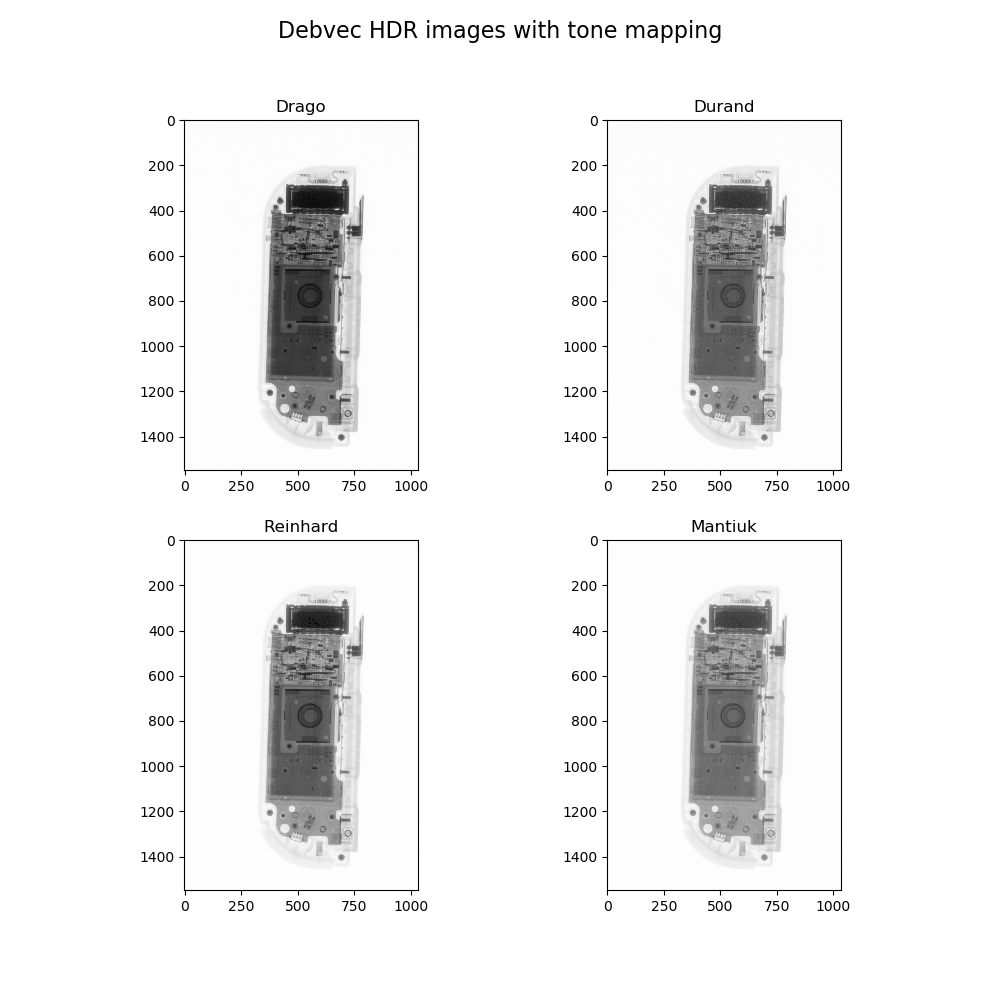

In [8]:
gamma = widgets.FloatSlider(min=-5, max=5, step=0.1, value=2.2, continuous_update=False)
refresh_button = widgets.Button(description='Refresh')

def on_button_clicked(b):
    drago = cv2.createTonemapDrago(gamma=gamma.value)
    durand = cv2.createTonemapDurand(gamma=gamma.value)
    reinhard = cv2.createTonemapReinhard(gamma=gamma.value)
    mantiuk = cv2.createTonemapMantiuk(gamma=gamma.value)
    
    ax[0,0].imshow(drago.process(hdr_debvec.copy()))
    ax[0,1].imshow(durand.process(hdr_debvec.copy()))
    ax[1,0].imshow(reinhard.process(hdr_debvec.copy()))
    ax[1,1].imshow(mantiuk.process(hdr_debvec.copy()))
    f.canvas.draw()
    
refresh_button.on_click(on_button_clicked)

print('Gamma:')
display(gamma)
display(refresh_button)
f, ax = plt.subplots(2, 2, figsize=(10, 10))
f.suptitle(f'Debvec HDR images with tone mapping', fontsize=16)
#plt.tight_layout()
ax[0,0].set_title('Drago')
ax[0,1].set_title('Durand')
ax[1,0].set_title('Reinhard')
ax[1,1].set_title('Mantiuk')

on_button_clicked(refresh_button)